In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
from bibliotheque import *
from cycle_detection import detect_respiration_cycles
from deform_tools import deform_to_cycle_template
from respiration_features import get_all_respiration_features
import tqdm
%matplotlib inline

## LOAD 

In [3]:
root = '/crnldata/'

In [4]:
stage_to_study = 'N2'

In [5]:
input_file = root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/dataarray/da_staged.nc'

In [6]:
da = xr.load_dataarray(input_file)#.dropna(dim='time').sel(stage = stage_to_study)

In [7]:
da = da.loc['N2',:,:].dropna(dim='time')
da

<xarray.DataArray (chan: 31, time: 2265600)>
array([[ 1.57316828e+01,  1.21813412e+01,  9.38920537e+00, ...,
         3.64174308e+01,  3.62686147e+01,  3.74392899e+01],
       [ 5.83001757e+01,  5.72083252e+01,  5.58677758e+01, ...,
         6.34570823e+01,  6.30250709e+01,  6.05690957e+01],
       [-1.19060935e+02, -1.19908883e+02, -1.20117212e+02, ...,
        -1.05141774e+02, -1.05864632e+02, -1.06282370e+02],
       ...,
       [-3.68261630e-01, -3.65724343e-01, -3.68702077e-01, ...,
        -3.74185157e-01, -3.75672758e-01, -3.75346825e-01],
       [ 2.69694168e-01,  2.59228093e-01,  2.38982679e-01, ...,
         2.64224363e-01,  2.60077143e-01,  2.87141293e-01],
       [ 8.23987182e-02,  8.23987182e-02,  8.23987182e-02, ...,
         8.23987182e-02,  8.23987182e-02,  8.23987182e-02]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 8.85e+03 8.85e+03 8.85e+03
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... '-' 'ANNOTATION'
    stage    <U2 'N2'

## PARAMS

In [8]:
chans = list(da.coords['chan'].values)
eeg_chans = ['Fp2-C4','C4-T4','T4-O2','Fz-Cz','Cz-Pz','Fp1-C3','C3-T3','T3-O1']
respi_chan = 'DEBIT'
ecg_chan = 'ECG'
eog_chans = ['EOGDt-A2','EOGG-A1']
sel_chans = ['Fp2-C4','C4-T4','T4-O2','Fz-Cz','Cz-Pz','Fp1-C3','C3-T3','T3-O1','DEBIT','ECG']
stages = ['W','R','N1','N2','N3']
srate = 256

In [9]:
save = False

In [10]:
save_presentation = False

## TOOLS

In [11]:
def stretch_data(resp_features, nb_point_by_cycle, data, srate):

    # params
    cycle_times = resp_features[['inspi_time', 'expi_time']].values
    mean_cycle_duration = np.mean(resp_features[['insp_duration', 'exp_duration']].values, axis=0)
    mean_inspi_ratio = mean_cycle_duration[0]/mean_cycle_duration.sum()
    times = np.arange(0,np.size(data))/srate

    clipped_times, times_to_cycles, cycles, cycle_points, data_stretch_linear = deform_to_cycle_template(
            data, times, cycle_times, nb_point_by_cycle=nb_point_by_cycle, inspi_ratio=0.4)

    nb_cycle = data_stretch_linear.shape[0]//nb_point_by_cycle
    phase = np.arange(nb_point_by_cycle)/nb_point_by_cycle
    data_stretch = data_stretch_linear.reshape(int(nb_cycle), int(nb_point_by_cycle))

    return data_stretch

In [12]:
def plot_cycle_points(resp, cycles, t , srate=srate, save_presentation=save_presentation):
    plt.figure()
    plt.plot(resp_sig)
    plt.plot(cycles[:,0], resp_sig[cycles[:,0]], 'o')
    plt.plot(cycles[:,1], resp_sig[cycles[:,1]], 'o')
    plt.xlim(t[0]*srate, t[1]*srate)
    plt.ylim(-20,20)
    plt.title('Resp signal (DEBIT) : cycle detection')
    if save_presentation:
        plt.savefig('../presentation/rsp_cycle_detection')
    plt.show()

## DATA SEL

In [13]:
resp_sig = da.loc['DEBIT',:].values
da_eeg = da.loc[eeg_chans,:]

## CYCLE DETECTION

In [14]:
cycles = detect_respiration_cycles(resp_sig, sampling_rate=srate, t_start = 0., output = 'index',

                                    # preprocessing
                                    inspiration_sign = '+',
                                    high_pass_filter = None,
                                    constrain_frequency = None,
                                    median_windows_filter = None,
                                    
                                    # baseline
                                    baseline_with_average = False,
                                    manual_baseline = 0.,
                                    
                                    # clean
                                    eliminate_time_shortest_ratio = 10,
                                    eliminate_amplitude_shortest_ratio = 10,
                                    eliminate_mode = 'OR', # 'AND'
                                    
                                    )

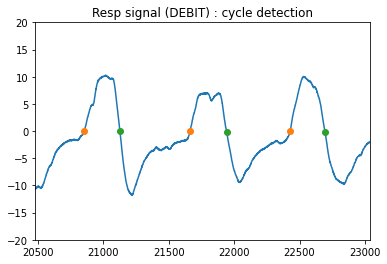

In [15]:
plot_cycle_points(resp=resp_sig, cycles=cycles, t=(80,90))

## RESP FEATURES FROM CYCLES & RESP

In [16]:
resp_features = get_all_respiration_features(resp_sig=resp_sig, sampling_rate=srate, cycles=cycles, t_start = 0.)

/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'objec

In [20]:
resp_features

,cycle_num,inspi_index,expi_index,inspi_time,expi_time,cycle_duration,insp_duration,exp_duration,cycle_freq,insp_volume,exp_volume,total_amplitude,insp_amplitude,exp_amplitude
0,0,156,430,0.609375,1.679688,2.960938,1.070312,1.890625,0.337731,7.877090,-10.504188,23.952921,11.693759,12.259161
1,1,914,1199,3.570312,4.683594,3.140625,1.113281,2.027344,0.318408,9.653313,-11.926609,30.184469,15.778508,14.405961
2,2,1718,1983,6.710938,7.746094,3.136719,1.035156,2.101562,0.318804,2.512008,-6.888079,11.839557,4.182194,7.657364
3,3,2521,2791,9.847656,10.902344,3.140625,1.054688,2.085938,0.318408,6.732685,-9.933996,22.142028,8.989756,13.152271
4,4,3325,3549,12.988281,13.863281,2.535156,0.875000,1.660156,0.394453,5.231098,-7.558556,20.618182,10.438046,10.180135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,3067,2261369,2261613,8833.472656,8834.425781,2.718750,0.953125,1.765625,0.367816,2.777774,-3.955319,9.860189,4.565180,5.295008
3068,3068,2262065,2262310,8836.191406,8837.148438,2.769531,0.957031,1.812500,0.361072,3.064045,-4.349727,11.061056,5.175310,5.885745
3069,3069,2262774,2263019,8838.960938,8839.917969,2.929688,0.957031,1.972656,0.341333,3.302590,-4.576394,10.838729,4.711241,6.127487
3070,3070,2263524,2263806,8841.890625,8842.992188,3.027344,1.101562,1.925781,0.330323,2.718081,-4.537920,9.510226,3.495103,6.015123


## STRETCHING NEURO DATA TO RESP CYCLES

In [17]:
da_stretched = None
for chan in eeg_chans:
    print(chan)
    data_stretch = stretch_data(resp_features=resp_features, nb_point_by_cycle=1000, data=da.loc[chan,:].values, srate=srate)
    if da_stretched is None:
        da_stretched = init_da({'chan':eeg_chans, 'cycle':np.arange(0,data_stretch.shape[0],1), 'point':np.arange(0,data_stretch.shape[1],1)})
    da_stretched.loc[chan, : , :] = data_stretch

Fp2-C4
C4-T4
T4-O2
Fz-Cz
Cz-Pz
Fp1-C3
C3-T3
T3-O1


In [18]:
if save:
    resp_features.to_excel(root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/df_analyse/resp_features.xlsx')
    da_stretched.to_netcdf(root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/dataarray/da_neuro_stretched.nc')

In [19]:
da_stretched

<xarray.DataArray (chan: 8, cycle: 3070, point: 1000)>
array([[[ 5.11265111e+01,  5.20595654e+01,  5.29766461e+01, ...,
         -7.46840337e+00, -7.96753397e+00, -7.77091174e+00],
        [-5.58094516e+00, -2.56113072e+00,  1.70630803e+00, ...,
          5.77021464e+01,  5.43337478e+01,  5.05708475e+01],
        [ 4.72518496e+01,  4.50482749e+01,  4.36575815e+01, ...,
          4.46633648e+00,  6.39806467e+00,  1.06414997e+01],
        ...,
        [ 1.59132663e+01,  1.51600994e+01,  1.43780348e+01, ...,
          3.61181667e+01,  3.50524585e+01,  3.43973181e+01],
        [ 3.42580402e+01,  3.40985106e+01,  3.40045955e+01, ...,
          1.73216878e+00,  2.94497487e+00,  3.91541988e+00],
        [ 4.60148712e+00,  4.88394445e+00,  5.10686434e+00, ...,
          2.49362645e+01,  2.45724114e+01,  2.38906348e+01]],

       [[ 5.59754192e+01,  5.68628143e+01,  5.76015085e+01, ...,
          5.88044173e+01,  5.68243495e+01,  5.43471643e+01],
        [ 5.13060425e+01,  4.87512377e+01,  4.62460735e+01, ...,
          1.36979820e+00,  3.78860205e+00,  6.40725122e+00],
        [ 7.44694751e+00,  8.49023096e+00,  9.16418596e+00, ...,
          6.36368455e+01,  6.58004273e+01,  6.77597369e+01],
...
        [-8.74842935e+01, -8.75651854e+01, -8.76236601e+01, ...,
         -1.16556694e+02, -1.14940162e+02, -1.13584661e+02],
        [-1.13076172e+02, -1.13645584e+02, -1.14002848e+02, ...,
         -9.41537569e+01, -9.40563084e+01, -9.39144486e+01],
        [-9.37501772e+01, -9.33946767e+01, -9.29676267e+01, ...,
         -9.42298828e+01, -9.12521740e+01, -8.80178156e+01]],

       [[ 1.77893640e+02,  1.77375685e+02,  1.76734079e+02, ...,
          1.59821548e+02,  1.60905178e+02,  1.62384034e+02],
        [ 1.63739211e+02,  1.64668754e+02,  1.66290236e+02, ...,
          2.43242295e+02,  2.48343490e+02,  2.52454944e+02],
        [ 2.55356160e+02,  2.57688621e+02,  2.60048052e+02, ...,
          1.61982769e+02,  1.63692311e+02,  1.65415825e+02],
        ...,
        [ 3.29786715e+01,  3.29839670e+01,  3.32945344e+01, ...,
          8.87100324e+01,  8.70956103e+01,  8.64141065e+01],
        [ 8.72445764e+01,  8.92307136e+01,  9.08114204e+01, ...,
          5.95224120e+01,  5.94247839e+01,  5.94229276e+01],
        [ 5.99490135e+01,  5.95127854e+01,  5.82724407e+01, ...,
          5.56275811e+01,  5.37203582e+01,  5.25974542e+01]]])
Coordinates:
  * chan     (chan) <U6 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'Fp1-C3' 'C3-T3' 'T3-O1'
  * cycle    (cycle) int64 0 1 2 3 4 5 6 ... 3063 3064 3065 3066 3067 3068 3069
  * point    (point) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

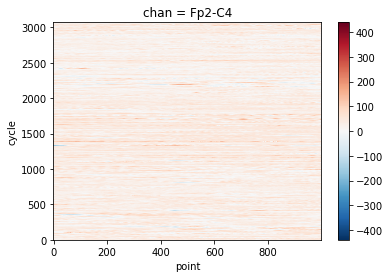

In [20]:
da_stretched.loc['Fp2-C4',:,:].plot.pcolormesh(x='point')

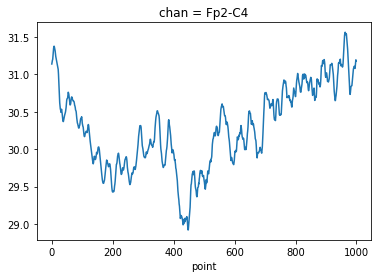

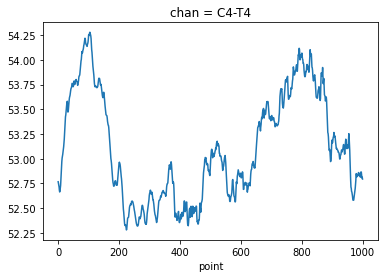

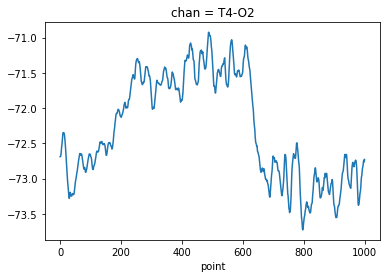

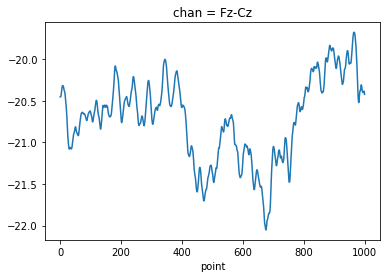

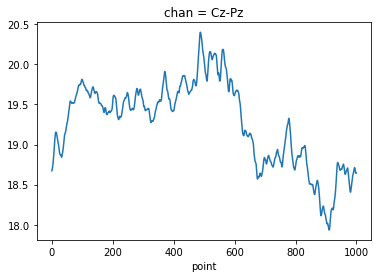

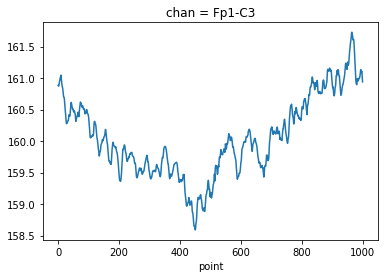

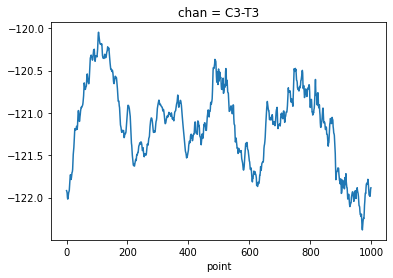

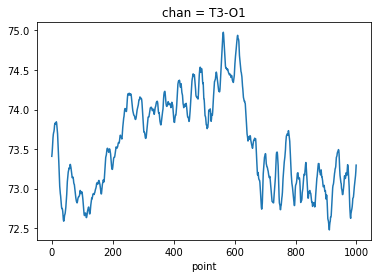

In [21]:
for chan in eeg_chans:
    plt.figure()
    da_stretched.loc[chan,:,:].mean('cycle').plot.line(x='point')
    plt.show()